In [1]:
import os
import cv2 as ocr
import pandas as pd
from os import path
import shutil
from tqdm import tqdm,trange
import sys
import gc
import os
from numpy.random import choice
from itertools import combinations
import numpy as np
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import math
from tqdm import tqdm
import keras as K
import matplotlib.pyplot as plt
from collections import Counter
from keras.utils import np_utils
import pandas as pd
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Activation,BatchNormalization,Lambda, Input, Conv2D, Dense,MaxPooling2D, Dropout, Flatten, UpSampling2D, Reshape

Using TensorFlow backend.


In [2]:
def getNextbatch(batch_size=10, stepNumber=0, imgDim = 128, imageFiles = 'list/of/files', pathSplitIndex = 2, classValLength = 4):
    import cv2 as ocr
    try:
        input_label_list = []
        input_data_list = []
        counter = 0
        start = stepNumber
        end = stepNumber + batch_size

        for imgF in imageFiles[start:end]:
          
            input_label_list.append(int(imgF.split('/')[pathSplitIndex][0:classValLength]))
            input_data_list.append(ocr.imread(imgF,0))

        return (np.array(input_data_list).reshape(-1,imgDim,imgDim,1)
                , np.array(input_label_list).astype('int64'))
    except Exception as e:
        print (e)
        
def getData(dataPath='path/To/Data',channels = 0, pathSplitIndex = 2, classValLength = 4, classCount = None, classValue = None):
    from os import listdir
    from os.path import isfile, join
    
    from tqdm import tqdm
    imageClass = []
    imageFiles = [] 
    input_label_list = []
    input_data_list = []   
    selectedFilePaths = []
    imageFiles = [dataPath+'/'+f for f in listdir(dataPath) if isfile(join(dataPath, f))]
    
    for imgF in tqdm(imageFiles, total=len(imageFiles), unit="files"): 
#         print(imgF)
        c = int(imgF.split('/')[pathSplitIndex][0:classValLength])
        if( classCount!=None and classValue == None):
            imageClass.append(c) 
            if(len(Counter(imageClass).keys())>classCount):
                imageClass[classCount] = imageClass[classCount-1]
            else:
#                 input_label_list.append(c)
#                 input_data_list.append(ocr.imread(imgF,channels))
                selectedFilePaths.append(imgF)
        elif(classCount==None and classValue!=None):
            if(c in classValue):
#                 input_label_list.append(c)
#                 input_data_list.append(ocr.imread(imgF,channels))
                selectedFilePaths.append(imgF)
        imageClass = list(set(imageClass))
    return np.array(selectedFilePaths)

def contrastive_loss(left_model, right_model, y, margin):
    with tf.name_scope("contrastive-loss"):
        d = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(left_model,right_model), 2), 1, keep_dims=True))
        part1= y * tf.square(d)    
        part2 = (1 - y) * tf.square(tf.maximum((margin - d),0))
        return tf.reduce_mean(part1 + part2) /2
    

images_folder_tr = 'images-32-lfw/'
images_folder_val = images_folder_tr
def gen_random_train_batch(nb_examples):
    out_l,out_r,out_y = [],[],[]
    li = random.sample(range(len(df_train)), nb_examples)
    for i in li:
        im_l = df_train.iloc[i]['name1']+"/"+df_train.iloc[i]['name1']+'_'+str(df_train.iloc[i]['im1']).zfill(4)+".jpg"
        im_r = df_train.iloc[i]['name2']+"/"+df_train.iloc[i]['name2']+'_'+str(df_train.iloc[i]['im2']).zfill(4)+".jpg"
        
        
        out_l.append(ocr.imread(images_folder_tr+im_l,0))
        out_r.append(ocr.imread(images_folder_tr+im_r,0))
        out_y.append(df_train.iloc[i]['label'])
    out_l = ((np.array(out_l))/255.0).astype('float32')
    out_r = ((np.array(out_r))/255.0).astype('float32')
    out_y = np.array(out_y).reshape((-1,1))
    return out_l.reshape(-1,imDim,imDim,1), out_r.reshape(-1,imDim,imDim,1), np.array(out_y)

def gen_random_val_batch(nb_examples):
    out_l,out_r,out_y = [],[],[]
    li = random.sample(range(len(df_val)), nb_examples)
    for i in li:
        
        im_l = df_val.iloc[i]['name1']+"/"+df_val.iloc[i]['name1']+'_'+str(df_val.iloc[i]['im1']).zfill(4)+".jpg"
        im_r = df_val.iloc[i]['name2']+"/"+df_val.iloc[i]['name2']+'_'+str(df_val.iloc[i]['im2']).zfill(4)+".jpg"
        
        
        out_l.append(ocr.imread(images_folder_val+im_l,0))
        out_r.append(ocr.imread(images_folder_val+im_r,0))
        out_y.append(df_val.iloc[i]['label'])
    out_l = ((np.array(out_l))/255.0).astype('float32')
    out_r = ((np.array(out_r))/255.0).astype('float32')
    out_y = np.array(out_y).reshape((-1,1))
    return out_l.reshape(-1,imDim,imDim,1), out_r.reshape(-1,imDim,imDim,1), np.array(out_y)

# def gen_random_train_batch_sift(nb_examples):
#     out_l,out_r,sift_l,sift_r,out_y = [],[],[],[],[]
#     li = random.sample(range(len(df_train)), nb_examples)
#     for i in li:
#         out_l.append(ocr.imread(images_folder_tr+df_train.iloc[i]['left'],0))
#         out_r.append(ocr.imread(images_folder_tr+df_train.iloc[i]['right'],0))
#         sift_l.append(df_train.iloc[i][3:259])
#         sift_r.append(df_train.iloc[i][259:])
#         out_y.append(df_train.iloc[i]['label'])
#     out_l = ((255.01 - np.array(out_l))/255.0).astype('float32')
#     out_r = ((255.01 - np.array(out_r))/255.0).astype('float32')
#     sift_l = np.array(sift_l).reshape((-1,256))
#     sift_r = np.array(sift_r).reshape((-1,256))
#     out_y = np.array(out_y).reshape((-1,1))
#     return out_l.reshape(-1,imDim,imDim,1), out_r.reshape(-1,imDim,imDim,1),sift_l,sift_r, out_y

# def gen_random_val_batch_sift(nb_examples):
#     out_l,out_r,sift_l,sift_r,out_y = [],[],[],[],[]
#     li = random.sample(range(len(df_val)), nb_examples)
#     for i in li:
#         out_l.append(ocr.imread(images_folder_val+df_val.iloc[i]['left'],0))
#         out_r.append(ocr.imread(images_folder_val+df_val.iloc[i]['right'],0))
#         sift_l.append(df_val.iloc[i][3:259])
#         sift_r.append(df_val.iloc[i][259:])
#         out_y.append(df_val.iloc[i]['label'])
#     out_l = ((255.01 - np.array(out_l))/255.0).astype('float32')
#     out_r = ((255.01 - np.array(out_r))/255.0).astype('float32')
#     sift_l = np.array(sift_l).reshape((-1,256))
#     sift_r = np.array(sift_r).reshape((-1,256))
#     out_y = np.array(out_y).reshape((-1,1))
#     return out_l.reshape(-1,imDim,imDim,1), out_r.reshape(-1,imDim,imDim,1),sift_l,sift_r, out_y


In [3]:
# from itertools import combinations
# def generateDatasetAndSave_Siamese():
#     label = []
#     left_path = []
#     right_path = []
#     simCounter = 0
#     for l,r in combinations(train_files_list,2):
#         if(int(l.split('/')[3][:4]) == int(r.split('/')[3][:4])):
#             label.append([1])
#     #     else:
#     #         label.append([0,1])
#             left_path.append(l)
#             right_path.append(r)
#             simCounter+=1
#     diffCounter = 0
#     for l,r in combinations(train_files_list,2):
#         if(int(l.split('/')[3][:4]) != int(r.split('/')[3][:4])):
#             label.append([0])
#     #     else:
#     #         label.append([0,1])
#             left_path.append(l)
#             right_path.append(r)
#             diffCounter+=1
#         if(diffCounter==simCounter):
#             break
#     df = pd.DataFrame()
#     pd.options.display.max_colwidth = 100
#     df['left'] = left_path
#     df['right'] = right_path
#     df['label'] = label
#     df.to_csv('dataset_training_siamese.csv')

### Sets params

In [4]:
imDim = 32
mode = 'concat'

### Create Feature extracter model

In [5]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9

set_session(tf.Session(config=config))

input_shape  = (imDim,imDim,1)
inp_img = Input(shape = (imDim,imDim,1), name = 'ImageInput')
model = inp_img

#     model = Input(shape=(imDim,imDim,1))
#     model.add(Input(shape = (imDim,imDim,1), name = 'FeatureNet_ImageInput'))
model = Conv2D(64,kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='same')(model)
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model = MaxPooling2D((2,2), padding='valid')(model)
model = Conv2D(128, (3, 3), activation='relu',padding='same')(model)
#     model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model = MaxPooling2D((2,2),padding='valid')(model)
model = Dropout(0.3)(model)
#     model.add(Conv2D(16, (3, 3), activation='relu',padding='same'))
model = Conv2D(256, (3, 3), activation='relu',padding='same')(model)
model = MaxPooling2D((2,2),padding='valid')(model)
#     model.add(Conv2D(1, (3, 3), activation='relu',padding='same'))
#     model.add(Conv2D(2, (3, 3), activation='relu',padding='same'))
model = Dropout(0.3)(model)
model = Conv2D(128, (1, 1), activation='relu',padding='valid')(model)
model = MaxPooling2D((2,2),padding='valid')(model)
model = Dropout(0.3)(model)
model = Conv2D(64, (1, 1), activation='relu',padding='valid')(model)
model = MaxPooling2D((2,2),padding='valid')(model)

model = Flatten()(model)

# img_in = np.array((-1,imDim,imDim,1), dtype='float32')
# img_in = tf.placeholder(shape=(imDim,imDim,1), dtype='float32')

feat = Model(inputs=[inp_img], outputs=[model],name = 'Feat_Model')
feat.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         295168    
__________

In [6]:
left_img = Input(shape = (imDim,imDim,1), name = 'left_img')
right_img = Input(shape = (imDim,imDim,1), name = 'right_img')
# left_sift = Input(shape= (256,), name = 'left_sift')
# right_sift = Input(shape= (256,), name = 'right_sift')

In [7]:
left_feats = feat(left_img)
right_feats = feat(right_img)

# inpTensor = Input((1,256,), name = 'SIFTInput')
# finalOut = Flatten()(inpTensor)  
# sift_model = Model(inputs=[inpTensor], outputs=[finalOut], name='Sift_Model')
# sift_model.summary()

# left_sift_feats = sift_model(left_sift)
# right_sift_feats = sift_model(right_sift)
# print(left_sift_feats)
print(left_feats)

Tensor("Feat_Model/flatten_1/Reshape:0", shape=(?, ?), dtype=float32)


In [8]:
from keras.layers import concatenate, subtract, multiply, division
from keras.utils import to_categorical
import random  

In [9]:

## CNN+SIFT
# merged_feats = concatenate([left_feats, right_feats, left_sift_feats, right_sift_feats], name = 'merged_feats')
## Only SIFT merge
# merged_feats = concatenate([left_sift_feats, right_sift_feats], name = 'merged_feats')
## Only CNN merge
if mode == 'concat':
    merged_feats = concatenate([left_feats, right_feats], name = 'merged_feats')
elif mode == 'subtract':
    merged_feats = subtract([left_feats, right_feats], name = 'merged_feats')
merged_feats = Dense(1024, activation = 'linear')(merged_feats)
merged_feats = BatchNormalization()(merged_feats)
merged_feats = Activation('relu')(merged_feats)
merged_feats = Dropout(0.3)(merged_feats)
merged_feats = Dense(4, activation = 'linear')(merged_feats)
merged_feats = BatchNormalization()(merged_feats)
merged_feats = Activation('relu')(merged_feats)
merged_feats = Dropout(0.3)(merged_feats)
merged_feats = Dense(2, activation = 'softmax')(merged_feats)
## only sift
# similarity_model = Model(inputs = [left_sift,right_sift], outputs = [merged_feats], name = 'Similarity_Model')
## only cnn
similarity_model = Model(inputs = [left_img, right_img], outputs = [merged_feats], name = 'Similarity_Model')
## with cnn+sift
# similarity_model = Model(inputs = [left_img, right_img, left_sift,right_sift], outputs = [merged_feats], name = 'Similarity_Model')
similarity_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_img (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
right_img (InputLayer)          (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
Feat_Model (Model)              (None, 64)           410816      left_img[0][0]                   
                                                                 right_img[0][0]                  
__________________________________________________________________________________________________
merged_feats (Concatenate)      (None, 128)          0           Feat_Model[1][0]                 
          

In [10]:
main_folder = ''
sgd = K.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
similarity_model.compile(optimizer=sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
# similarity_model.load_weights('weights/weights-siamese-AND-concat-cnn-0.377613.hdf5')

In [11]:
train_set = 'pairsDevTrain.csv'
val_set = 'pairsDevTest.csv'
df_train = pd.DataFrame.from_csv(train_set).reset_index()
df_val = pd.DataFrame.from_csv(val_set).reset_index()
df_train.shape[0]


2200

In [12]:
df_val.shape[0]

1000

In [13]:
# iteration = 0
# left_image = ocr.imread(df.iloc[iteration]['left'],0)
# right_image = ocr.imread(df.iloc[iteration]['right'],0)
# y = df.iloc[iteration]['label']


In [14]:
n_epochs = 100
batch_size = 64
imgDim =  imDim
best_loss_tr = np.infty
max_val_acc = 0
train_files_list = df_train.shape[0]
train_num_examples = train_files_list
print('Train on: %2d, Validate on: %2d' %(train_num_examples, df_val.shape[0]))
n_iterations_per_epoch = train_num_examples // batch_size
# n_iterations_validation = val_num_examples // batch_size
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.0
sess = tf.Session()
sess.run(tf.global_variables_initializer())
tr_loss_vals = []
tr_acc_vals = []
val_acc_vals = []
v_batch_size = df_val.shape[0]
early_stopping_counter = 0
patience = 20


batch_metrics = None
batch_metric_loss = []
batch_metric_acc = []
for epoch in range(n_epochs):
    for iteration in range(int(train_files_list/batch_size)):        
        left_image, right_image, y = gen_random_train_batch(batch_size)
        y = to_categorical(y)
#         print('\n------\n'+str(y)+'\n------\n')
        left_image = left_image.reshape((-1, imgDim, imgDim, 1))
        right_image = right_image.reshape((-1, imgDim, imgDim, 1))
#         batch_metrics = similarity_model.train_on_batch([left_image,right_image,sift_l,sift_r],[y])
#         batch_metrics = similarity_model.train_on_batch([sift_l,sift_r],[y])
        batch_metrics = similarity_model.train_on_batch([left_image,right_image],[y])
        
        batch_metric_loss.append(batch_metrics[0])
        batch_metric_acc.append(batch_metrics[1])
        print("\rTraining the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_per_epoch,
                  iteration * 100 / n_iterations_per_epoch),
              end="" * 10)
    loss_tr = np.mean(batch_metric_loss)
    acc_tr = np.mean(batch_metric_acc)
    tr_loss_vals.append(loss_tr)
    tr_acc_vals.append(acc_tr)
    
    v_left_image ,v_right_image, v_y = gen_random_val_batch(v_batch_size)
    
#     pred_sim = similarity_model.predict([v_left_image ,v_right_image,v_sift_l, v_sift_r])
#     pred_sim = similarity_model.predict([v_sift_l, v_sift_r])
    pred_sim = similarity_model.predict([v_left_image ,v_right_image])
    pred_val_sim = []
    for p in pred_sim:
        pred_val_sim.append(np.argmax(p))
    v_acc = float((np.array(pred_val_sim).reshape((v_batch_size,1))==v_y).sum())/float(len(v_y))
    val_acc_vals.append(v_acc)
    
    print("\rEpoch: {}  Train accuracy: {:.4f}%, Tr Loss: {:.6f}, Validation acc: {:.4f}% {}".format(
        epoch + 1,
        (acc_tr) * 100,
        (v_acc)*100.0, loss_tr,
        " (improved)" if v_acc > max_val_acc else ""))
    if loss_tr < best_loss_tr:
        best_loss_tr = loss_tr        
    if max_val_acc < v_acc:
        max_val_acc = v_acc
        early_stopping_counter = 0
        filepath='weights/siam-'+str(imgDim)+'-cnn-'+mode+'-[val-acc-'+str(v_acc)+'].hdf5'
        similarity_model.save(filepath)
    else:
        early_stopping_counter+=1
    if early_stopping_counter==patience:
        print('early stopped - no increase in val acc over previous '+str(patience)+' epochs')
        break


Train on: 2200, Validate on: 1000
Epoch: 1  Train accuracy: 50.5515%, Tr Loss: 50.100000, Validation acc: 0.8117%  (improved)
Epoch: 2  Train accuracy: 49.0809%, Tr Loss: 50.000000, Validation acc: 0.8118% 
Epoch: 3  Train accuracy: 49.0502%, Tr Loss: 50.000000, Validation acc: 0.8036% 
Epoch: 4  Train accuracy: 49.1958%, Tr Loss: 50.000000, Validation acc: 0.8073% 
Epoch: 5  Train accuracy: 49.1912%, Tr Loss: 50.000000, Validation acc: 0.8070% 
Epoch: 6  Train accuracy: 49.3719%, Tr Loss: 50.000000, Validation acc: 0.8029% 
Epoch: 7  Train accuracy: 49.4288%, Tr Loss: 50.000000, Validation acc: 0.8007% 
Epoch: 8  Train accuracy: 49.4658%, Tr Loss: 50.000000, Validation acc: 0.7981% 
Epoch: 9  Train accuracy: 49.5966%, Tr Loss: 50.000000, Validation acc: 0.7943% 
Epoch: 10  Train accuracy: 49.5910%, Tr Loss: 50.000000, Validation acc: 0.7924% 
Epoch: 11  Train accuracy: 49.6574%, Tr Loss: 50.000000, Validation acc: 0.7912% 
Epoch: 12  Train accuracy: 49.7779%, Tr Loss: 50.300000, Valid

In [15]:
df_metrics = pd.DataFrame()
df_metrics['accuracy'] = tr_acc_vals
df_metrics['loss'] = tr_loss_vals
df_metrics['val_acc'] = val_acc_vals
df_metrics.to_csv('plots/siam-'+str(imgDim)+'-cnn-'+mode+'-metric-cnn.csv')


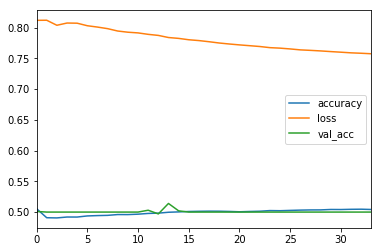

In [16]:
%matplotlib inline
ax = df_metrics.plot()
fig = ax.figure
fig.savefig('plots/siam-'+str(imgDim)+'-cnn-'+mode+'-plot-cnn.png')

[[ 0.10931647  0.89068353]
 [ 0.11014311  0.88985687]
 [ 0.09808031  0.90191966]
 [ 0.12725055  0.87274951]
 [ 0.09270382  0.90729618]]


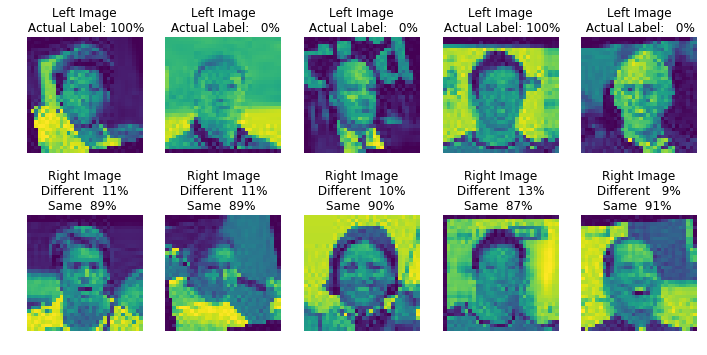

In [17]:
# similarity_model = load model (best one)
%matplotlib inline
def show_model_output(nb_examples = 5):
    
#     pv_a, pv_b,pv_s_l,pv_s_r, pv_sim = gen_random_val_batch(nb_examples)
    pv_a, pv_b, pv_sim = gen_random_val_batch(nb_examples)
#     pred_sim = similarity_model.predict([pv_a, pv_b,pv_s_l,pv_s_r])
    pred_sim = similarity_model.predict([pv_a, pv_b])
    p_val_argmax=[]
    print(pred_sim)
    for p in pred_sim:
        p_val_argmax.append(np.argmax(p))
    p_val_argmax = np.array(p_val_argmax)
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Left Image\n Actual Label: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Right Image\n Different %3.0f%% \nSame %3.0f%% ' % (100*p_d[0],100*p_d[1]))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [18]:
v_left_image ,v_right_image, v_y = gen_random_val_batch(100)
pred_sim = similarity_model.predict([v_left_image ,v_right_image])
(pred_sim.round().astype('int')==v_y).sum()

100

In [19]:
l,r,y = gen_random_train_batch(3)

In [20]:
y.shape

(3, 1)

In [21]:
import random
random.sample(range(1, 10), 3)

[1, 5, 7]

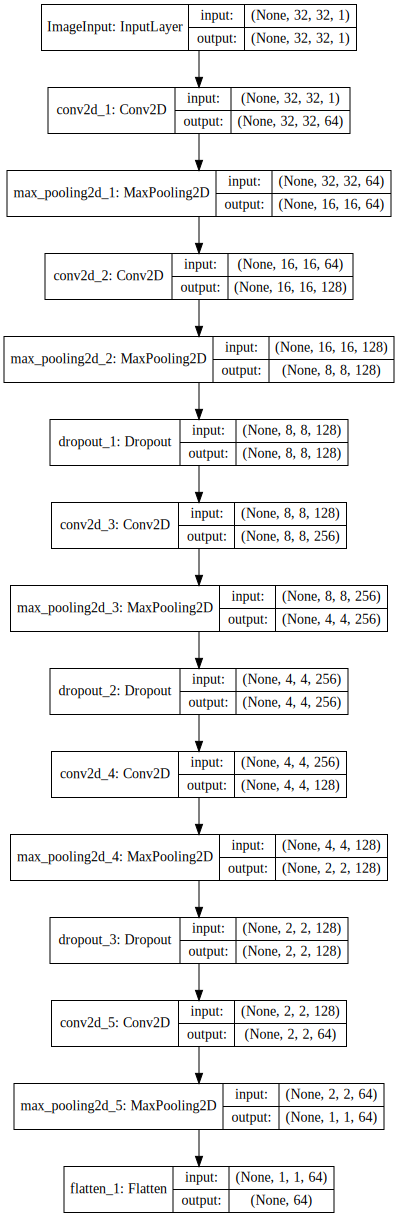

In [22]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(feat, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

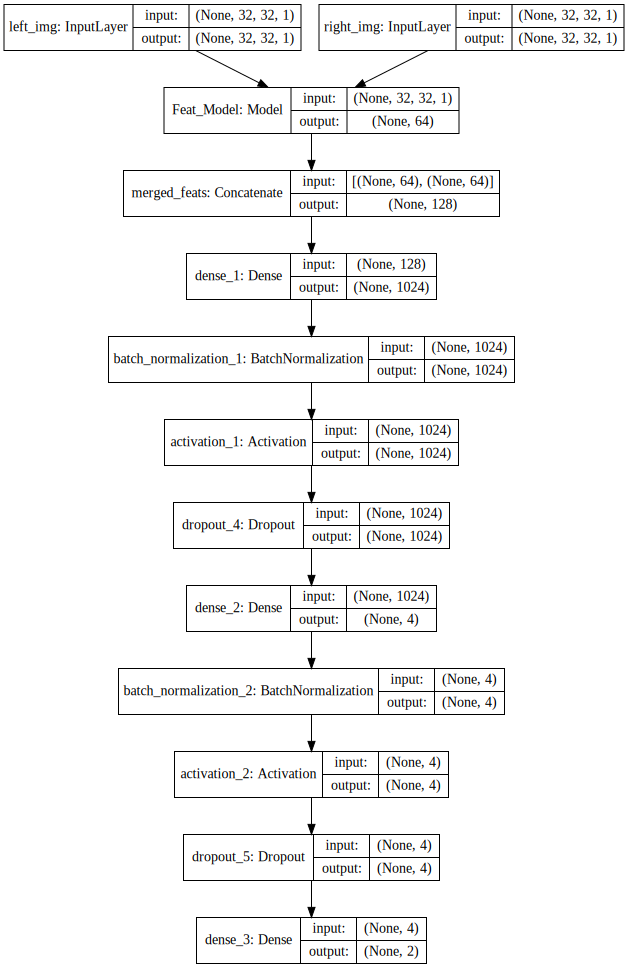

In [23]:
SVG(model_to_dot(similarity_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [24]:
batch_metrics

[0.74758273, 0.390625]

In [25]:
a = np.array([1,1,1,1,1,1,1,1,0])
b = np.array([1,1,1,1,1,1,1,1,0,0])
(a==b).sum()

C:\Anaconda3\Lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


AttributeError: 'bool' object has no attribute 'sum'

In [ ]:
l,r,s,y = gen_random_val_batch_sift(1)

In [ ]:
s.shape

In [ ]:
feat.summary()